# Import packages

In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_selector as selector
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
%matplotlib inline
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['legend.numpoints'] = 1
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Import dataset

In [2]:
df = pd.read_csv('./data/LI_et_al_well_parameter_dataset.csv')
df.columns = df.columns.astype(str)
df = df.loc[:, ~df.columns.isin(['Unnamed: 0'])]

# Split training and test set

In [3]:
# Specify predictors and the target variable
X = df.copy()
y = df['scp_and_or_cvf']

# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, shuffle=True, random_state=1)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Function to create geospatial metrics (well count and well distance)

In [4]:
# DataFrame: the dataframe containing the wells for which we are calculating geospatial metrics
# DataFrame_ball: the dataframe we use to generate the Ball Tree
def calc_count_dist(DataFrame, DataFrame_ball, radii):
    df= DataFrame.reset_index(drop=True)
    df_ball = DataFrame_ball.reset_index(drop=True)
    
    for column in ["latitude", "longitude"]:
        df[f'{column}_rad'] = np.deg2rad(df[column].values)
        df_ball[f'{column}_rad'] = np.deg2rad(df_ball[column].values)
        
    earth_r_km = 6371 # the radius of earth in km  
    df_ball_all = df_ball.copy()
    ball_all = BallTree(df_ball_all[["latitude_rad", "longitude_rad"]].values, metric='haversine')# BallTree of all wells in df_ball
    df_ball_faulty = df_ball.loc[df_ball['scp_and_or_cvf'],:].reset_index(drop=True)
    ball_faulty = BallTree(df_ball_faulty[["latitude_rad", "longitude_rad"]].values, metric='haversine')# BallTree of only faulty wells in df_ball
    df_ball_nonFaulty = df_ball.loc[~df_ball['scp_and_or_cvf'],:].reset_index(drop=True)
    ball_nonFaulty = BallTree(df_ball_nonFaulty[["latitude_rad", "longitude_rad"]].values, metric='haversine')# BallTree of only non-faulty wells in df_ball
    ball_list = [ball_all, ball_faulty, ball_nonFaulty]
    df_list = [df_ball_all, df_ball_faulty, df_ball_nonFaulty]
    ball_labels = ['well', 'faulty_well', 'nonFaulty_well']
    nb_dist_cols = ['distance_to_nearest_well_km', 'distance_to_nearest_faulty_well_km','distance_to_nearest_nonFaulty_well_km']
    
    for ball_i in range(len(ball_list)):
        
        # 1. calculate distance to the nearest neighbour:
        ball = ball_list[ball_i]
        df_ball_cur = df_list[ball_i]
        ball_label = ball_labels[ball_i]
        dist_knn, ind_knn = ball.query(df[["latitude_rad", "longitude_rad"]], k = 2)
        dist_knn = dist_knn * earth_r_km # calculate distance to nearest neighbor    
        # ind responds to row number in df_ball_cur
        # We test if the nearest neighbour is the queried well itself by comparing their API numbers. If that's the case, we use the 2nd nearest neighbour instead.
        df_ind_knn = pd.DataFrame(ind_knn)
        ind_first = df_ind_knn.iloc[:,0]
        ind_second = df_ind_knn.iloc[:,1]
        api_ind_first = df_ball_cur.iloc[ind_first,df_ball.columns.get_loc('api')].reset_index(drop=True)
        api_ind_second = df_ball_cur.iloc[ind_second,df_ball.columns.get_loc('api')].reset_index(drop=True)
        nearest_is_self = api_ind_first == df.loc[:,'api'].reset_index(drop=True)
        # Calculate distance to nearest neighbour, excluding self:    
        df_dist_knn = pd.DataFrame(dist_knn).round(3)
        dist_nb = df_dist_knn.iloc[:, 0] # distance to the nearest neighbour
        dist_nb.loc[nearest_is_self] = df_dist_knn.loc[nearest_is_self, 1]
        dist_col_name = 'distance_to_nearest_' + ball_label + '_km'
        df[dist_col_name] = dist_nb        
        api_nb = api_ind_first # API number of the nearest neighbour
        api_nb.loc[nearest_is_self] = api_ind_second
        api_col_name = 'API_of_nearest_' + ball_label
        
        # 2. calculate well counts within a radius:       
        for rad_i in range(len(radii)): 
            radius = radii[rad_i]
            radius_rad = radius/earth_r_km
            count_list = []
            queries = ball.query_radius(df[["latitude_rad", "longitude_rad"]], r=radius_rad)
            for ind,q in enumerate(queries):
                # The index in q is just the order, instead of the original index in df_ball_cur, so df_ball_cur needs to reset its index
                # Exclude the index of self
                self_api = df.iloc[ind, df.columns.get_loc("api")]            
                count = 0
                for i in q:
                    neighbor_api = df_ball_cur.iloc[i,df_ball_cur.columns.get_loc("api")]
                    if neighbor_api != self_api:
                        count += 1
                count_list.append(count)
            df['count_'+ball_label+f"_within_{radius}km"] = count_list  
            # Calculate the incremental well count for the current radius
            # e.g., increment_count_1km = count_1km - count_0.1 km
            if rad_i > 0:
                prev_radius = radii[rad_i - 1]
                df['count_' + ball_label + f"_between_{prev_radius}_and_{radius}km"] = df['count_'+ball_label+f"_within_{radius}km"] - df['count_'+ball_label+f"_within_{prev_radius}km"]
        # Drop the columns of well count within radius (non-incremental)
        radius_metric_to_remove = []
        for drop_i in range(1, len(radii)):
            radius = radii[drop_i]
            radius_metric_to_remove.append('count_'+ball_label+f"_within_{radius}km")
        df = df.drop(radius_metric_to_remove, axis = 1)
    # drop rad columns
    for column in ["latitude", "longitude"]:
        df = df.drop(f'{column}_rad', axis=1)
    return df

# Split the training set into Cross-Validation (CV) training sets and CV validation sets, and append geospatial metrics

In [5]:
radii  = [0.005,0.01,0.1,1,2,5,10]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = cv.split(X_train, y_train)

X_cv_train_self_lst = [] # 'self' indicates only using physical parameters of the well itself as predictors
X_cv_train_spatial_lst = [] # 'spatial' indicates also using geospatial metrics
X_cv_val_self_lst = []
X_cv_val_spatial_lst = []
y_cv_train_lst = []
y_cv_val_lst = []

for cv_train_index, cv_val_index in splits:
    X_cv_train_self = X_train.iloc[cv_train_index,:].reset_index(drop=True)
    X_cv_val_self = X_train.iloc[cv_val_index,:].reset_index(drop=True)
    y_cv_train = y_train.iloc[cv_train_index].reset_index(drop=True)
    y_cv_val = y_train.iloc[cv_val_index].reset_index(drop=True)
    X_cv_train_spatial = calc_count_dist(DataFrame=X_cv_train_self, DataFrame_ball = X_cv_train_self, radii=radii)
    X_cv_val_spatial = calc_count_dist(DataFrame=X_cv_val_self, DataFrame_ball=X_cv_train_self, radii=radii)
     
    X_cv_train_spatial = X_cv_train_spatial.drop(['scp_and_or_cvf','api'], axis = 1)
    X_cv_val_spatial = X_cv_val_spatial.drop(['scp_and_or_cvf', 'api'], axis = 1)
    X_cv_train_self = X_cv_train_self.drop(['latitude', 'longitude','scp_and_or_cvf','api'], axis = 1)
    X_cv_val_self = X_cv_val_self.drop(['latitude', 'longitude','scp_and_or_cvf','api'], axis = 1)
    
    X_cv_train_self_lst.append(X_cv_train_self)
    X_cv_val_self_lst.append(X_cv_val_self)
    X_cv_train_spatial_lst.append(X_cv_train_spatial)
    X_cv_val_spatial_lst.append(X_cv_val_spatial)
    y_cv_train_lst.append(y_cv_train)
    y_cv_val_lst.append(y_cv_val) 

# Append geospatial metrics to the complete training set and test set

In [6]:
X_train_self = X_train.copy()
X_train_spatial = calc_count_dist(DataFrame = X_train_self, DataFrame_ball=X_train_self, radii=radii)
X_train_spatial =X_train_spatial.drop(['scp_and_or_cvf','api'], axis = 1)
X_train_self = X_train_self.drop(['latitude', 'longitude','scp_and_or_cvf','api'], axis = 1)

X_test_self = X_test.copy()
X_test_spatial = calc_count_dist(DataFrame = X_test_self, DataFrame_ball = X_train, radii = radii)
X_test_spatial =X_test_spatial.drop(['scp_and_or_cvf','api'], axis = 1)
X_test_self = X_test_self.drop(['latitude', 'longitude','scp_and_or_cvf','api'], axis = 1)

# Function to evaluate a model (pipeline) on each CV train and val set

In [7]:
def cv_evaluation(pipeline, param_grid, X_train, y_train, X_cv_train_lst, y_cv_train_lst, X_cv_val_lst, y_cv_val_lst):
    params=[]
    cv_mean_score = []
    cv_std_score = []
    grid = ParameterGrid(param_grid)
    total_param_comb = len(grid)
    count_comb = 0
    for g in grid:
        params.append(g)
        pipeline_g = pipeline.set_params(**g)
        scores_g = []
        for i in range(len(X_cv_train_lst)):
            X_cv_train = X_cv_train_lst[i]
            y_cv_train = y_cv_train_lst[i]
            X_cv_val = X_cv_val_lst[i]
            y_cv_val = y_cv_val_lst[i]
            pipeline_fitted = pipeline_g.fit(X_cv_train, y_cv_train)
            y_cv_val_pred = pipeline_fitted.predict(X_cv_val)
            y_cv_val_pred_prob = pipeline_fitted.predict_proba(X_cv_val)[:,1]  
            score_cur = roc_auc_score(y_cv_val,y_cv_val_pred_prob) # Use ROC_AUC as evaluation metric
            scores_g.append(score_cur)
        np_scores_g = np.array(scores_g)
        mean_scores_g = np.mean(np_scores_g)
        cv_mean_score.append(mean_scores_g)
        std_scores_g = np.std(np_scores_g)
        cv_std_score.append(std_scores_g)
        count_comb+=1
        print(f'Finished evaluating {count_comb}/{total_param_comb} hyperparameter combinations.')
        
    cv_grid_results = pd.DataFrame({'Params':params, 'mean_score': cv_mean_score, 'std_score': cv_std_score})
    max_score_idx = cv_grid_results['mean_score'].idxmax()
    best_mean_score = cv_grid_results.loc[max_score_idx, 'mean_score']
    best_std_score = cv_grid_results.loc[max_score_idx, 'std_score']
    best_param = cv_grid_results.loc[max_score_idx, 'Params']
    best_pipeline = pipeline.set_params(**best_param)
    best_pipeline = best_pipeline.fit(X_train, y_train) # re-fit the best model on the whole training set
    
    return cv_grid_results, best_mean_score, best_std_score,best_param,best_pipeline

# Preprocessor to be used in pipeline

In [8]:
def create_preprocessor():

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median"))]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude=["object", 'bool'])),
            ("cat", categorical_transformer, selector(dtype_include=["object"])),
        ],
        sparse_threshold = 0,
        remainder = 'passthrough'
    )
    
    return preprocessor

# Train and evaluate machine learning models

## 1. Estimator = Random Forrest

### Using all features (i.e., local and geospatial features)

In [9]:
rng = np.random.RandomState(0)

rf_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng,n_jobs=-1))
]

rf_clf_pl = Pipeline(steps = rf_steps)

rf_param_grid = {"UniSlct__percentile" : [80, 90, 100],
 'est__max_depth': [ 5, 50, 100,500, 1000, None],
 'est__max_features': ['sqrt', 'log2'],
 'est__n_estimators': [100, 200, 1000, 2000]}

# Train and evaluate model using CV
start_time_rf = time.perf_counter()
cv_table_rf, score_rf, std_rf,param_rf,pipeline_rf = cv_evaluation(rf_clf_pl, rf_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_rf = time.perf_counter()
elapsed_time_rf = end_time_rf - start_time_rf
print("Elapsed time in sec: ", elapsed_time_rf)

Finished evaluating 1/144 hyperparameter combinations.
Finished evaluating 2/144 hyperparameter combinations.
Finished evaluating 3/144 hyperparameter combinations.
Finished evaluating 4/144 hyperparameter combinations.
Finished evaluating 5/144 hyperparameter combinations.
Finished evaluating 6/144 hyperparameter combinations.
Finished evaluating 7/144 hyperparameter combinations.
Finished evaluating 8/144 hyperparameter combinations.
Finished evaluating 9/144 hyperparameter combinations.
Finished evaluating 10/144 hyperparameter combinations.
Finished evaluating 11/144 hyperparameter combinations.
Finished evaluating 12/144 hyperparameter combinations.
Finished evaluating 13/144 hyperparameter combinations.
Finished evaluating 14/144 hyperparameter combinations.
Finished evaluating 15/144 hyperparameter combinations.
Finished evaluating 16/144 hyperparameter combinations.
Finished evaluating 17/144 hyperparameter combinations.
Finished evaluating 18/144 hyperparameter combinations.
F

In [10]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_rf, param_rf))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.7596879256066593, while the selected hyper-parameters are: {'UniSlct__percentile': 100, 'est__max_depth': 1000, 'est__max_features': 'sqrt', 'est__n_estimators': 2000}


### Excluding geospatial features (i.e., only concerning local features of the well itself)

In [11]:
rng = np.random.RandomState(0)# Reset the random states

rf_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng, n_jobs=-1))
]

rf_clf_pl_self = Pipeline(steps = rf_steps_self)

rf_param_grid_self = {"UniSlct__percentile" : [ 80, 90, 100],
 'est__max_depth': [5, 50, 100,300, 500, 700, None],
 'est__max_features': ['sqrt', 'log2'],
 'est__n_estimators': [100, 200, 1000, 2000, 4000]}

start_time_rf = time.perf_counter()
cv_table_rf_self, score_rf_self, std_rf_self,param_rf_self,pipeline_rf_self = cv_evaluation(rf_clf_pl_self, rf_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_rf = time.perf_counter()
elapsed_time_rf = end_time_rf - start_time_rf
print("Elapsed time in sec: ", elapsed_time_rf)

Finished evaluating 1/210 hyperparameter combinations.
Finished evaluating 2/210 hyperparameter combinations.
Finished evaluating 3/210 hyperparameter combinations.
Finished evaluating 4/210 hyperparameter combinations.
Finished evaluating 5/210 hyperparameter combinations.
Finished evaluating 6/210 hyperparameter combinations.
Finished evaluating 7/210 hyperparameter combinations.
Finished evaluating 8/210 hyperparameter combinations.
Finished evaluating 9/210 hyperparameter combinations.
Finished evaluating 10/210 hyperparameter combinations.
Finished evaluating 11/210 hyperparameter combinations.
Finished evaluating 12/210 hyperparameter combinations.
Finished evaluating 13/210 hyperparameter combinations.
Finished evaluating 14/210 hyperparameter combinations.
Finished evaluating 15/210 hyperparameter combinations.
Finished evaluating 16/210 hyperparameter combinations.
Finished evaluating 17/210 hyperparameter combinations.
Finished evaluating 18/210 hyperparameter combinations.
F

Finished evaluating 147/210 hyperparameter combinations.
Finished evaluating 148/210 hyperparameter combinations.
Finished evaluating 149/210 hyperparameter combinations.
Finished evaluating 150/210 hyperparameter combinations.
Finished evaluating 151/210 hyperparameter combinations.
Finished evaluating 152/210 hyperparameter combinations.
Finished evaluating 153/210 hyperparameter combinations.
Finished evaluating 154/210 hyperparameter combinations.
Finished evaluating 155/210 hyperparameter combinations.
Finished evaluating 156/210 hyperparameter combinations.
Finished evaluating 157/210 hyperparameter combinations.
Finished evaluating 158/210 hyperparameter combinations.
Finished evaluating 159/210 hyperparameter combinations.
Finished evaluating 160/210 hyperparameter combinations.
Finished evaluating 161/210 hyperparameter combinations.
Finished evaluating 162/210 hyperparameter combinations.
Finished evaluating 163/210 hyperparameter combinations.
Finished evaluating 164/210 hyp

In [12]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_rf_self, param_rf_self))

Using only physical features, the best CV score during hyper-parameter search is 0.7288542769967731, while the selected hyper-parameters are: {'UniSlct__percentile': 100, 'est__max_depth': 700, 'est__max_features': 'sqrt', 'est__n_estimators': 200}


## 2. Estimator = XGBoost

### Using all features

In [13]:
rng = np.random.RandomState(0)
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=rng,
                             subsample=0.9,
                             colsample_bytree=0.5)

xgb_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", xgb_estimator)
]

xgb_clf_pl = Pipeline(steps = xgb_steps)

xgb_param_grid = {
     "UniSlct__percentile" : [80, 90, 100],
     'est__max_depth': [ 30, 40, 50, 60, 70],
     'est__learning_rate': [ 1e-4,1e-3,1e-2, 1e-1],
     'est__gamma': [0, 1e-2, 1e-1, 1],
     'est__reg_lambda': [0, 1e-9, 1e-6]
    }

start_time_xgb = time.perf_counter()
cv_table_xgb,score_xgb, std_xgb,param_xgb,pipeline_xgb = cv_evaluation(xgb_clf_pl, xgb_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_xgb = time.perf_counter()
elapsed_time_xgb = end_time_xgb - start_time_xgb
print("Elapsed time in sec: ", elapsed_time_xgb)

Finished evaluating 1/720 hyperparameter combinations.
Finished evaluating 2/720 hyperparameter combinations.
Finished evaluating 3/720 hyperparameter combinations.
Finished evaluating 4/720 hyperparameter combinations.
Finished evaluating 5/720 hyperparameter combinations.
Finished evaluating 6/720 hyperparameter combinations.
Finished evaluating 7/720 hyperparameter combinations.
Finished evaluating 8/720 hyperparameter combinations.
Finished evaluating 9/720 hyperparameter combinations.
Finished evaluating 10/720 hyperparameter combinations.
Finished evaluating 11/720 hyperparameter combinations.
Finished evaluating 12/720 hyperparameter combinations.
Finished evaluating 13/720 hyperparameter combinations.
Finished evaluating 14/720 hyperparameter combinations.
Finished evaluating 15/720 hyperparameter combinations.
Finished evaluating 16/720 hyperparameter combinations.
Finished evaluating 17/720 hyperparameter combinations.
Finished evaluating 18/720 hyperparameter combinations.
F

Finished evaluating 147/720 hyperparameter combinations.
Finished evaluating 148/720 hyperparameter combinations.
Finished evaluating 149/720 hyperparameter combinations.
Finished evaluating 150/720 hyperparameter combinations.
Finished evaluating 151/720 hyperparameter combinations.
Finished evaluating 152/720 hyperparameter combinations.
Finished evaluating 153/720 hyperparameter combinations.
Finished evaluating 154/720 hyperparameter combinations.
Finished evaluating 155/720 hyperparameter combinations.
Finished evaluating 156/720 hyperparameter combinations.
Finished evaluating 157/720 hyperparameter combinations.
Finished evaluating 158/720 hyperparameter combinations.
Finished evaluating 159/720 hyperparameter combinations.
Finished evaluating 160/720 hyperparameter combinations.
Finished evaluating 161/720 hyperparameter combinations.
Finished evaluating 162/720 hyperparameter combinations.
Finished evaluating 163/720 hyperparameter combinations.
Finished evaluating 164/720 hyp

Finished evaluating 291/720 hyperparameter combinations.
Finished evaluating 292/720 hyperparameter combinations.
Finished evaluating 293/720 hyperparameter combinations.
Finished evaluating 294/720 hyperparameter combinations.
Finished evaluating 295/720 hyperparameter combinations.
Finished evaluating 296/720 hyperparameter combinations.
Finished evaluating 297/720 hyperparameter combinations.
Finished evaluating 298/720 hyperparameter combinations.
Finished evaluating 299/720 hyperparameter combinations.
Finished evaluating 300/720 hyperparameter combinations.
Finished evaluating 301/720 hyperparameter combinations.
Finished evaluating 302/720 hyperparameter combinations.
Finished evaluating 303/720 hyperparameter combinations.
Finished evaluating 304/720 hyperparameter combinations.
Finished evaluating 305/720 hyperparameter combinations.
Finished evaluating 306/720 hyperparameter combinations.
Finished evaluating 307/720 hyperparameter combinations.
Finished evaluating 308/720 hyp

Finished evaluating 435/720 hyperparameter combinations.
Finished evaluating 436/720 hyperparameter combinations.
Finished evaluating 437/720 hyperparameter combinations.
Finished evaluating 438/720 hyperparameter combinations.
Finished evaluating 439/720 hyperparameter combinations.
Finished evaluating 440/720 hyperparameter combinations.
Finished evaluating 441/720 hyperparameter combinations.
Finished evaluating 442/720 hyperparameter combinations.
Finished evaluating 443/720 hyperparameter combinations.
Finished evaluating 444/720 hyperparameter combinations.
Finished evaluating 445/720 hyperparameter combinations.
Finished evaluating 446/720 hyperparameter combinations.
Finished evaluating 447/720 hyperparameter combinations.
Finished evaluating 448/720 hyperparameter combinations.
Finished evaluating 449/720 hyperparameter combinations.
Finished evaluating 450/720 hyperparameter combinations.
Finished evaluating 451/720 hyperparameter combinations.
Finished evaluating 452/720 hyp

Finished evaluating 579/720 hyperparameter combinations.
Finished evaluating 580/720 hyperparameter combinations.
Finished evaluating 581/720 hyperparameter combinations.
Finished evaluating 582/720 hyperparameter combinations.
Finished evaluating 583/720 hyperparameter combinations.
Finished evaluating 584/720 hyperparameter combinations.
Finished evaluating 585/720 hyperparameter combinations.
Finished evaluating 586/720 hyperparameter combinations.
Finished evaluating 587/720 hyperparameter combinations.
Finished evaluating 588/720 hyperparameter combinations.
Finished evaluating 589/720 hyperparameter combinations.
Finished evaluating 590/720 hyperparameter combinations.
Finished evaluating 591/720 hyperparameter combinations.
Finished evaluating 592/720 hyperparameter combinations.
Finished evaluating 593/720 hyperparameter combinations.
Finished evaluating 594/720 hyperparameter combinations.
Finished evaluating 595/720 hyperparameter combinations.
Finished evaluating 596/720 hyp

In [14]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_xgb, param_xgb))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.7543396248916556, while the selected hyper-parameters are: {'UniSlct__percentile': 80, 'est__gamma': 1, 'est__learning_rate': 0.01, 'est__max_depth': 50, 'est__reg_lambda': 0}


### Excluding geospatial features

In [15]:
rng = np.random.RandomState(0)
xgb_estimator_self = xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=rng,
                             subsample=0.9,
                             colsample_bytree=0.5)

xgb_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", xgb_estimator_self)
]

xgb_clf_pl_self = Pipeline(steps = xgb_steps_self)

xgb_param_grid_self = {
     "UniSlct__percentile" : [70, 80, 90, 100],
     'est__max_depth': [ 10, 20, 30, 40],
     'est__learning_rate': [1e-7,1e-6,1e-5,1e-4],
     'est__gamma': [1e-8, 1e-7,1e-6,1e-5],
     'est__reg_lambda':  [1e-4, 1e-3, 1e-2, 1e-1],
    }

start_time_xgb = time.perf_counter()
cv_table_xgb_self, score_xgb_self, std_xgb_self,param_xgb_self,pipeline_xgb_self = cv_evaluation(xgb_clf_pl_self, xgb_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_xgb = time.perf_counter()
elapsed_time_xgb = end_time_xgb - start_time_xgb
print("Elapsed time in sec: ", elapsed_time_xgb)

Finished evaluating 1/1024 hyperparameter combinations.
Finished evaluating 2/1024 hyperparameter combinations.
Finished evaluating 3/1024 hyperparameter combinations.
Finished evaluating 4/1024 hyperparameter combinations.
Finished evaluating 5/1024 hyperparameter combinations.
Finished evaluating 6/1024 hyperparameter combinations.
Finished evaluating 7/1024 hyperparameter combinations.
Finished evaluating 8/1024 hyperparameter combinations.
Finished evaluating 9/1024 hyperparameter combinations.
Finished evaluating 10/1024 hyperparameter combinations.
Finished evaluating 11/1024 hyperparameter combinations.
Finished evaluating 12/1024 hyperparameter combinations.
Finished evaluating 13/1024 hyperparameter combinations.
Finished evaluating 14/1024 hyperparameter combinations.
Finished evaluating 15/1024 hyperparameter combinations.
Finished evaluating 16/1024 hyperparameter combinations.
Finished evaluating 17/1024 hyperparameter combinations.
Finished evaluating 18/1024 hyperparamet

Finished evaluating 145/1024 hyperparameter combinations.
Finished evaluating 146/1024 hyperparameter combinations.
Finished evaluating 147/1024 hyperparameter combinations.
Finished evaluating 148/1024 hyperparameter combinations.
Finished evaluating 149/1024 hyperparameter combinations.
Finished evaluating 150/1024 hyperparameter combinations.
Finished evaluating 151/1024 hyperparameter combinations.
Finished evaluating 152/1024 hyperparameter combinations.
Finished evaluating 153/1024 hyperparameter combinations.
Finished evaluating 154/1024 hyperparameter combinations.
Finished evaluating 155/1024 hyperparameter combinations.
Finished evaluating 156/1024 hyperparameter combinations.
Finished evaluating 157/1024 hyperparameter combinations.
Finished evaluating 158/1024 hyperparameter combinations.
Finished evaluating 159/1024 hyperparameter combinations.
Finished evaluating 160/1024 hyperparameter combinations.
Finished evaluating 161/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 287/1024 hyperparameter combinations.
Finished evaluating 288/1024 hyperparameter combinations.
Finished evaluating 289/1024 hyperparameter combinations.
Finished evaluating 290/1024 hyperparameter combinations.
Finished evaluating 291/1024 hyperparameter combinations.
Finished evaluating 292/1024 hyperparameter combinations.
Finished evaluating 293/1024 hyperparameter combinations.
Finished evaluating 294/1024 hyperparameter combinations.
Finished evaluating 295/1024 hyperparameter combinations.
Finished evaluating 296/1024 hyperparameter combinations.
Finished evaluating 297/1024 hyperparameter combinations.
Finished evaluating 298/1024 hyperparameter combinations.
Finished evaluating 299/1024 hyperparameter combinations.
Finished evaluating 300/1024 hyperparameter combinations.
Finished evaluating 301/1024 hyperparameter combinations.
Finished evaluating 302/1024 hyperparameter combinations.
Finished evaluating 303/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 429/1024 hyperparameter combinations.
Finished evaluating 430/1024 hyperparameter combinations.
Finished evaluating 431/1024 hyperparameter combinations.
Finished evaluating 432/1024 hyperparameter combinations.
Finished evaluating 433/1024 hyperparameter combinations.
Finished evaluating 434/1024 hyperparameter combinations.
Finished evaluating 435/1024 hyperparameter combinations.
Finished evaluating 436/1024 hyperparameter combinations.
Finished evaluating 437/1024 hyperparameter combinations.
Finished evaluating 438/1024 hyperparameter combinations.
Finished evaluating 439/1024 hyperparameter combinations.
Finished evaluating 440/1024 hyperparameter combinations.
Finished evaluating 441/1024 hyperparameter combinations.
Finished evaluating 442/1024 hyperparameter combinations.
Finished evaluating 443/1024 hyperparameter combinations.
Finished evaluating 444/1024 hyperparameter combinations.
Finished evaluating 445/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 571/1024 hyperparameter combinations.
Finished evaluating 572/1024 hyperparameter combinations.
Finished evaluating 573/1024 hyperparameter combinations.
Finished evaluating 574/1024 hyperparameter combinations.
Finished evaluating 575/1024 hyperparameter combinations.
Finished evaluating 576/1024 hyperparameter combinations.
Finished evaluating 577/1024 hyperparameter combinations.
Finished evaluating 578/1024 hyperparameter combinations.
Finished evaluating 579/1024 hyperparameter combinations.
Finished evaluating 580/1024 hyperparameter combinations.
Finished evaluating 581/1024 hyperparameter combinations.
Finished evaluating 582/1024 hyperparameter combinations.
Finished evaluating 583/1024 hyperparameter combinations.
Finished evaluating 584/1024 hyperparameter combinations.
Finished evaluating 585/1024 hyperparameter combinations.
Finished evaluating 586/1024 hyperparameter combinations.
Finished evaluating 587/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 713/1024 hyperparameter combinations.
Finished evaluating 714/1024 hyperparameter combinations.
Finished evaluating 715/1024 hyperparameter combinations.
Finished evaluating 716/1024 hyperparameter combinations.
Finished evaluating 717/1024 hyperparameter combinations.
Finished evaluating 718/1024 hyperparameter combinations.
Finished evaluating 719/1024 hyperparameter combinations.
Finished evaluating 720/1024 hyperparameter combinations.
Finished evaluating 721/1024 hyperparameter combinations.
Finished evaluating 722/1024 hyperparameter combinations.
Finished evaluating 723/1024 hyperparameter combinations.
Finished evaluating 724/1024 hyperparameter combinations.
Finished evaluating 725/1024 hyperparameter combinations.
Finished evaluating 726/1024 hyperparameter combinations.
Finished evaluating 727/1024 hyperparameter combinations.
Finished evaluating 728/1024 hyperparameter combinations.
Finished evaluating 729/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 855/1024 hyperparameter combinations.
Finished evaluating 856/1024 hyperparameter combinations.
Finished evaluating 857/1024 hyperparameter combinations.
Finished evaluating 858/1024 hyperparameter combinations.
Finished evaluating 859/1024 hyperparameter combinations.
Finished evaluating 860/1024 hyperparameter combinations.
Finished evaluating 861/1024 hyperparameter combinations.
Finished evaluating 862/1024 hyperparameter combinations.
Finished evaluating 863/1024 hyperparameter combinations.
Finished evaluating 864/1024 hyperparameter combinations.
Finished evaluating 865/1024 hyperparameter combinations.
Finished evaluating 866/1024 hyperparameter combinations.
Finished evaluating 867/1024 hyperparameter combinations.
Finished evaluating 868/1024 hyperparameter combinations.
Finished evaluating 869/1024 hyperparameter combinations.
Finished evaluating 870/1024 hyperparameter combinations.
Finished evaluating 871/1024 hyperparameter combinations.
Finished evalu

Finished evaluating 997/1024 hyperparameter combinations.
Finished evaluating 998/1024 hyperparameter combinations.
Finished evaluating 999/1024 hyperparameter combinations.
Finished evaluating 1000/1024 hyperparameter combinations.
Finished evaluating 1001/1024 hyperparameter combinations.
Finished evaluating 1002/1024 hyperparameter combinations.
Finished evaluating 1003/1024 hyperparameter combinations.
Finished evaluating 1004/1024 hyperparameter combinations.
Finished evaluating 1005/1024 hyperparameter combinations.
Finished evaluating 1006/1024 hyperparameter combinations.
Finished evaluating 1007/1024 hyperparameter combinations.
Finished evaluating 1008/1024 hyperparameter combinations.
Finished evaluating 1009/1024 hyperparameter combinations.
Finished evaluating 1010/1024 hyperparameter combinations.
Finished evaluating 1011/1024 hyperparameter combinations.
Finished evaluating 1012/1024 hyperparameter combinations.
Finished evaluating 1013/1024 hyperparameter combinations.


In [16]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_xgb_self, param_xgb_self))

Using only physical features, the best CV score during hyper-parameter search is 0.7339814814073162, while the selected hyper-parameters are: {'UniSlct__percentile': 80, 'est__gamma': 1e-08, 'est__learning_rate': 1e-07, 'est__max_depth': 30, 'est__reg_lambda': 0.01}


## 3. Estimator = Logistic Regression

### Using all features

In [17]:
rng = np.random.RandomState(0)

lg_param_grid = {
 "UniSlct__percentile" : [5, 10, 25, 50, 75],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

lg_estimator = LogisticRegression(max_iter = 500, solver = 'liblinear', random_state = rng)

lg_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", lg_estimator)
]

lg_clf_pl = Pipeline(steps = lg_steps)

start_time_lg = time.perf_counter()
cv_table_lg,score_lg, std_lg,param_lg,pipeline_lg = cv_evaluation(lg_clf_pl, lg_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_lg = time.perf_counter()
elapsed_time_lg = end_time_lg - start_time_lg
print("Elapsed time in sec: ", elapsed_time_lg)

Finished evaluating 1/50 hyperparameter combinations.
Finished evaluating 2/50 hyperparameter combinations.
Finished evaluating 3/50 hyperparameter combinations.
Finished evaluating 4/50 hyperparameter combinations.
Finished evaluating 5/50 hyperparameter combinations.
Finished evaluating 6/50 hyperparameter combinations.
Finished evaluating 7/50 hyperparameter combinations.
Finished evaluating 8/50 hyperparameter combinations.
Finished evaluating 9/50 hyperparameter combinations.
Finished evaluating 10/50 hyperparameter combinations.
Finished evaluating 11/50 hyperparameter combinations.
Finished evaluating 12/50 hyperparameter combinations.
Finished evaluating 13/50 hyperparameter combinations.
Finished evaluating 14/50 hyperparameter combinations.
Finished evaluating 15/50 hyperparameter combinations.
Finished evaluating 16/50 hyperparameter combinations.
Finished evaluating 17/50 hyperparameter combinations.
Finished evaluating 18/50 hyperparameter combinations.
Finished evaluating

In [18]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_lg, param_lg))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.7382648771596221, while the selected hyper-parameters are: {'UniSlct__percentile': 25, 'est__C': 0.01, 'est__penalty': 'l2'}


### Excluding geospatial features

In [19]:
rng = np.random.RandomState(0)

lg_param_grid_self = {
 "UniSlct__percentile" : [5, 10, 25, 50, 75],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-3, 1e-2, 1e-1, 1, 10]
}

lg_estimator_self = LogisticRegression(max_iter = 500, solver = 'liblinear', random_state = rng)

lg_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", lg_estimator_self)
]

lg_clf_pl_self = Pipeline(steps = lg_steps_self)

start_time_lg_self = time.perf_counter()
cv_table_lg_self, score_lg_self, std_lg_self,param_lg_self,pipeline_lg_self = cv_evaluation(lg_clf_pl_self, lg_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_lg_self = time.perf_counter()
elapsed_time_lg_self = end_time_lg_self - start_time_lg_self
print("Elapsed time in sec: ", elapsed_time_lg_self)

Finished evaluating 1/50 hyperparameter combinations.
Finished evaluating 2/50 hyperparameter combinations.
Finished evaluating 3/50 hyperparameter combinations.
Finished evaluating 4/50 hyperparameter combinations.
Finished evaluating 5/50 hyperparameter combinations.
Finished evaluating 6/50 hyperparameter combinations.
Finished evaluating 7/50 hyperparameter combinations.
Finished evaluating 8/50 hyperparameter combinations.
Finished evaluating 9/50 hyperparameter combinations.
Finished evaluating 10/50 hyperparameter combinations.
Finished evaluating 11/50 hyperparameter combinations.
Finished evaluating 12/50 hyperparameter combinations.
Finished evaluating 13/50 hyperparameter combinations.
Finished evaluating 14/50 hyperparameter combinations.
Finished evaluating 15/50 hyperparameter combinations.
Finished evaluating 16/50 hyperparameter combinations.
Finished evaluating 17/50 hyperparameter combinations.
Finished evaluating 18/50 hyperparameter combinations.
Finished evaluating

In [20]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_lg_self, param_lg_self))

Using only physical features, the best CV score during hyper-parameter search is 0.6932023215746083, while the selected hyper-parameters are: {'UniSlct__percentile': 50, 'est__C': 0.001, 'est__penalty': 'l2'}


## 4. Estimator = Logistic Regression with Interaction Terms

### Using all features

In [21]:
rng = np.random.RandomState(0)

lgp_estimator = LogisticRegression(max_iter = 500, solver = 'liblinear', random_state = rng)

lgp_steps = [
     ("pre", create_preprocessor()),
     ('poly', PolynomialFeatures(degree = 2)),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectKBest(f_classif)),
     ("est", lgp_estimator)
]

lgp_param_grid = [{
 "UniSlct__k" : [10, 50, 100, 500],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-4,1e-2, 1e0,1e2, 1e4]

},{
 "UniSlct__k" : [500, 1000,3000,5000,7000],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-8,1e-6,1e-4,1e-2]

}]

lgp_clf_pl = Pipeline(steps = lgp_steps)

start_time_lgp = time.perf_counter()
cv_table_lgp, score_lgp, std_lgp,param_lgp,pipeline_lgp = cv_evaluation(lgp_clf_pl, lgp_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_lgp = time.perf_counter()
elapsed_time_lgp = end_time_lgp - start_time_lgp
print("Elapsed time in sec: ", elapsed_time_lgp)

Finished evaluating 1/80 hyperparameter combinations.
Finished evaluating 2/80 hyperparameter combinations.
Finished evaluating 3/80 hyperparameter combinations.
Finished evaluating 4/80 hyperparameter combinations.
Finished evaluating 5/80 hyperparameter combinations.
Finished evaluating 6/80 hyperparameter combinations.
Finished evaluating 7/80 hyperparameter combinations.
Finished evaluating 8/80 hyperparameter combinations.
Finished evaluating 9/80 hyperparameter combinations.
Finished evaluating 10/80 hyperparameter combinations.
Finished evaluating 11/80 hyperparameter combinations.
Finished evaluating 12/80 hyperparameter combinations.
Finished evaluating 13/80 hyperparameter combinations.
Finished evaluating 14/80 hyperparameter combinations.
Finished evaluating 15/80 hyperparameter combinations.
Finished evaluating 16/80 hyperparameter combinations.
Finished evaluating 17/80 hyperparameter combinations.
Finished evaluating 18/80 hyperparameter combinations.
Finished evaluating

In [22]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_lgp, param_lgp))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.7367043494458564, while the selected hyper-parameters are: {'UniSlct__k': 3000, 'est__C': 0.0001, 'est__penalty': 'l2'}


### Excluding geospatial features

In [23]:
rng = np.random.RandomState(0)

lgp_param_grid_self = [{
 "UniSlct__k" : [10, 50, 100, 500],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-4,1e-2, 1e0,1e2, 1e4]

},{
 "UniSlct__k" : [500, 1000, 3000,5000, 7000],
    "est__penalty": ['l1', 'l2'],
    "est__C": [1e-8,1e-6,1e-4, 1e-2, 1]
}]

lgp_estimator_self = LogisticRegression(max_iter = 500, solver = 'liblinear', random_state = rng)

lgp_steps_self = [
     ("pre", create_preprocessor()),
     ('poly', PolynomialFeatures(degree = 2)),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectKBest(f_classif)),
     ("est", lgp_estimator_self)
]

lgp_clf_pl_self = Pipeline(steps = lgp_steps_self)

start_time_lgp_self = time.perf_counter()
cv_table_lgp_self, score_lgp_self, std_lgp_self,param_lgp_self,pipeline_lgp_self = cv_evaluation(lgp_clf_pl_self, lgp_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_lgp_self = time.perf_counter()
elapsed_time_lgp_self = end_time_lgp_self - start_time_lgp_self
print("Elapsed time in sec: ", elapsed_time_lgp_self)

Finished evaluating 1/90 hyperparameter combinations.
Finished evaluating 2/90 hyperparameter combinations.
Finished evaluating 3/90 hyperparameter combinations.
Finished evaluating 4/90 hyperparameter combinations.
Finished evaluating 5/90 hyperparameter combinations.
Finished evaluating 6/90 hyperparameter combinations.
Finished evaluating 7/90 hyperparameter combinations.
Finished evaluating 8/90 hyperparameter combinations.
Finished evaluating 9/90 hyperparameter combinations.
Finished evaluating 10/90 hyperparameter combinations.
Finished evaluating 11/90 hyperparameter combinations.
Finished evaluating 12/90 hyperparameter combinations.
Finished evaluating 13/90 hyperparameter combinations.
Finished evaluating 14/90 hyperparameter combinations.
Finished evaluating 15/90 hyperparameter combinations.
Finished evaluating 16/90 hyperparameter combinations.
Finished evaluating 17/90 hyperparameter combinations.
Finished evaluating 18/90 hyperparameter combinations.
Finished evaluating

In [24]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_lgp_self, param_lgp_self))

Using only physical features, the best CV score during hyper-parameter search is 0.6931468177715764, while the selected hyper-parameters are: {'UniSlct__k': 7000, 'est__C': 0.0001, 'est__penalty': 'l2'}


## 5. Estimator = Support Vector Machine

### Using all features

In [25]:
rng = np.random.RandomState(0)

default_gamma = 1/X_train.shape[1] #~ 0.01

svm_estimator = svm.SVC(cache_size = 2000, kernel = 'rbf', probability=True, random_state=rng)

svm_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", svm_estimator)
]

svm_clf_pl = Pipeline(steps = svm_steps)

svm_param_grid = {"UniSlct__percentile": [1, 5, 10, 25, 50, 75],
    "est__C": [0.1, 1, 10, 100, 1000],
    "est__gamma":[default_gamma*0.001,default_gamma*0.01,default_gamma*0.1,default_gamma*1,default_gamma*10]}

start_time_svm = time.perf_counter()
cv_table_svm,score_svm, std_svm,param_svm,pipeline_svm = cv_evaluation(svm_clf_pl, svm_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_svm = time.perf_counter()
elapsed_time_svm = end_time_svm - start_time_svm
print("Elapsed time in sec: ", elapsed_time_svm)

Finished evaluating 1/150 hyperparameter combinations.
Finished evaluating 2/150 hyperparameter combinations.
Finished evaluating 3/150 hyperparameter combinations.
Finished evaluating 4/150 hyperparameter combinations.
Finished evaluating 5/150 hyperparameter combinations.
Finished evaluating 6/150 hyperparameter combinations.
Finished evaluating 7/150 hyperparameter combinations.
Finished evaluating 8/150 hyperparameter combinations.
Finished evaluating 9/150 hyperparameter combinations.
Finished evaluating 10/150 hyperparameter combinations.
Finished evaluating 11/150 hyperparameter combinations.
Finished evaluating 12/150 hyperparameter combinations.
Finished evaluating 13/150 hyperparameter combinations.
Finished evaluating 14/150 hyperparameter combinations.
Finished evaluating 15/150 hyperparameter combinations.
Finished evaluating 16/150 hyperparameter combinations.
Finished evaluating 17/150 hyperparameter combinations.
Finished evaluating 18/150 hyperparameter combinations.
F

Finished evaluating 147/150 hyperparameter combinations.
Finished evaluating 148/150 hyperparameter combinations.
Finished evaluating 149/150 hyperparameter combinations.
Finished evaluating 150/150 hyperparameter combinations.
Elapsed time in sec:  136.9431814999998


In [26]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_svm, param_svm))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.73352159148222, while the selected hyper-parameters are: {'UniSlct__percentile': 25, 'est__C': 1, 'est__gamma': 0.008264462809917356}


### Excluding geospatial features

In [27]:
rng = np.random.RandomState(0)

default_gamma = 1/X_train_self.shape[1] # ~ 0.011

svm_estimator_self = svm.SVC(cache_size = 2000, kernel = 'rbf',probability=True, random_state=rng)

svm_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", svm_estimator_self)
]

svm_clf_pl_self = Pipeline(steps = svm_steps_self)

svm_param_grid_self = {
    "UniSlct__percentile": [5, 10, 25, 50, 75],
    "est__C": [0.1, 1, 10, 100, 1000],
    "est__gamma":[default_gamma*0.001, default_gamma*0.01, default_gamma*0.1,default_gamma*1]
}

start_time_svm_self = time.perf_counter()
cv_table_svm_self,score_svm_self, std_svm_self,param_svm_self,pipeline_svm_self = cv_evaluation(svm_clf_pl_self, svm_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_svm_self = time.perf_counter()
elapsed_time_svm_self = end_time_svm_self - start_time_svm_self
print("Elapsed time in sec: ", elapsed_time_svm)

Finished evaluating 1/100 hyperparameter combinations.
Finished evaluating 2/100 hyperparameter combinations.
Finished evaluating 3/100 hyperparameter combinations.
Finished evaluating 4/100 hyperparameter combinations.
Finished evaluating 5/100 hyperparameter combinations.
Finished evaluating 6/100 hyperparameter combinations.
Finished evaluating 7/100 hyperparameter combinations.
Finished evaluating 8/100 hyperparameter combinations.
Finished evaluating 9/100 hyperparameter combinations.
Finished evaluating 10/100 hyperparameter combinations.
Finished evaluating 11/100 hyperparameter combinations.
Finished evaluating 12/100 hyperparameter combinations.
Finished evaluating 13/100 hyperparameter combinations.
Finished evaluating 14/100 hyperparameter combinations.
Finished evaluating 15/100 hyperparameter combinations.
Finished evaluating 16/100 hyperparameter combinations.
Finished evaluating 17/100 hyperparameter combinations.
Finished evaluating 18/100 hyperparameter combinations.
F

In [28]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_svm_self, param_svm_self))

Using only physical features, the best CV score during hyper-parameter search is 0.689081263210132, while the selected hyper-parameters are: {'UniSlct__percentile': 50, 'est__C': 1, 'est__gamma': 0.0008547008547008548}


## 6. Estimator = K-Nearest Neighbour

### Using all features

In [29]:
knn_estimator = KNeighborsClassifier(n_jobs=-1)

knn_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", knn_estimator)
]
knn_clf_pl = Pipeline(steps = knn_steps)

knn_param_grid = {
    "UniSlct__percentile": [ 10, 25, 50, 75, 100],
    "est__weights": ['uniform', 'distance'],
    "est__n_neighbors": [10,20, 30, 40, 50]
}

start_time_knn = time.perf_counter()
cv_table_knn,score_knn, std_knn,param_knn,pipeline_knn = cv_evaluation(knn_clf_pl, knn_param_grid, X_train_spatial, y_train, X_cv_train_spatial_lst,y_cv_train_lst,X_cv_val_spatial_lst,y_cv_val_lst)
end_time_knn = time.perf_counter()
elapsed_time_knn = end_time_knn - start_time_knn
print("Elapsed time in sec: ", elapsed_time_knn)

Finished evaluating 1/50 hyperparameter combinations.
Finished evaluating 2/50 hyperparameter combinations.
Finished evaluating 3/50 hyperparameter combinations.
Finished evaluating 4/50 hyperparameter combinations.
Finished evaluating 5/50 hyperparameter combinations.
Finished evaluating 6/50 hyperparameter combinations.
Finished evaluating 7/50 hyperparameter combinations.
Finished evaluating 8/50 hyperparameter combinations.
Finished evaluating 9/50 hyperparameter combinations.
Finished evaluating 10/50 hyperparameter combinations.
Finished evaluating 11/50 hyperparameter combinations.
Finished evaluating 12/50 hyperparameter combinations.
Finished evaluating 13/50 hyperparameter combinations.
Finished evaluating 14/50 hyperparameter combinations.
Finished evaluating 15/50 hyperparameter combinations.
Finished evaluating 16/50 hyperparameter combinations.
Finished evaluating 17/50 hyperparameter combinations.
Finished evaluating 18/50 hyperparameter combinations.
Finished evaluating

In [30]:
print('Using physical and geospatial features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_knn, param_knn))

Using physical and geospatial features, the best CV score during hyper-parameter search is 0.7175341288537274, while the selected hyper-parameters are: {'UniSlct__percentile': 25, 'est__n_neighbors': 40, 'est__weights': 'distance'}


### Excluding geospatial features

In [31]:
knn_estimator_self = KNeighborsClassifier(n_jobs=-1)

knn_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", knn_estimator_self)
]
knn_clf_pl_self = Pipeline(steps = knn_steps_self)

knn_param_grid_self = {
    "UniSlct__percentile": [10, 25, 50, 75, 100],
    "est__weights": ['uniform', 'distance'],
    "est__n_neighbors": [  30, 50, 70, 90, 110, 130]
}

start_time_knn_self = time.perf_counter()
cv_table_knn_self,score_knn_self, std_knn_self,param_knn_self,pipeline_knn_self = cv_evaluation(knn_clf_pl_self, knn_param_grid_self, X_train_self, y_train, X_cv_train_self_lst,y_cv_train_lst,X_cv_val_self_lst,y_cv_val_lst)
end_time_knn_self = time.perf_counter()
elapsed_time_knn_self = end_time_knn_self - start_time_knn_self
print("Elapsed time in sec: ", elapsed_time_knn_self)

Finished evaluating 1/60 hyperparameter combinations.
Finished evaluating 2/60 hyperparameter combinations.
Finished evaluating 3/60 hyperparameter combinations.
Finished evaluating 4/60 hyperparameter combinations.
Finished evaluating 5/60 hyperparameter combinations.
Finished evaluating 6/60 hyperparameter combinations.
Finished evaluating 7/60 hyperparameter combinations.
Finished evaluating 8/60 hyperparameter combinations.
Finished evaluating 9/60 hyperparameter combinations.
Finished evaluating 10/60 hyperparameter combinations.
Finished evaluating 11/60 hyperparameter combinations.
Finished evaluating 12/60 hyperparameter combinations.
Finished evaluating 13/60 hyperparameter combinations.
Finished evaluating 14/60 hyperparameter combinations.
Finished evaluating 15/60 hyperparameter combinations.
Finished evaluating 16/60 hyperparameter combinations.
Finished evaluating 17/60 hyperparameter combinations.
Finished evaluating 18/60 hyperparameter combinations.
Finished evaluating

In [32]:
print('Using only physical features, the best CV score during hyper-parameter search is {}, while the selected hyper-parameters are: {}'.format(score_knn_self, param_knn_self))

Using only physical features, the best CV score during hyper-parameter search is 0.7080477443953975, while the selected hyper-parameters are: {'UniSlct__percentile': 50, 'est__n_neighbors': 90, 'est__weights': 'distance'}


# Plot the cross-validation score of each model

In [33]:
models = ['RF', 'XGB', 'LR', 'LR-IA', 'SVM','KNN']

mean_scores_best_models = {
    'All features':np.array([score_rf, score_xgb, score_lg, score_lgp, score_svm, score_knn]),
    'No geospatial features':np.array([score_rf_self, score_xgb_self, score_lg_self, score_lgp_self,score_svm_self,score_knn_self])
}

std_scores_best_models = {
    'All features':np.array([std_rf, std_xgb, std_lg, std_lgp,std_svm,std_knn]),
    'No geospatial features':np.array([std_rf_self, std_xgb_self, std_lg_self, std_lgp_self,std_svm_self, std_knn_self])
}

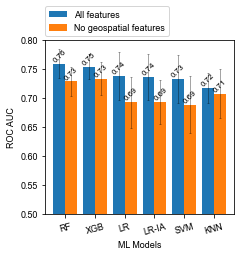

In [34]:
x = np.arange(len(models))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(1,1, figsize=(3.4,3.2))

for feature_choice, score in mean_scores_best_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, score, width, label=feature_choice)
    ax.bar_label(rects, padding=1, fmt = '%.2f', size=8,  rotation = 45)
    error = std_scores_best_models[feature_choice]
    ax.errorbar(x + offset, score, yerr = error, fmt = 'none',color = 'black', capsize = 1, capthick = 0.5,elinewidth=0.5, alpha = 0.7)
    multiplier += 1

ax.set_ylabel('ROC AUC', size = 9)
ax.set_xlabel('ML Models', size = 9)
ax.set_xticks(ticks = x + 0.5*width)
ax.set_xticklabels(models)
ax.tick_params(labelrotation=15,axis='x', which='major', labelsize=9)
ax.tick_params(axis='y', which='major', labelsize=9)
#handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left', ncol=1, fontsize = 9, bbox_to_anchor=(-0.02, 1.22))
ax.set_ylim(0.5, 0.8)

plt.savefig('./Figures/main_text/models_cv_comparison.png',bbox_inches='tight',dpi=300)

# Plot ROC of each model. Fit and evaluate on the first CV split

ROC AUC of RF using all features including geospatial ones is: 0.7342624491074224
ROC AUC of RF excluding geospatial features is: 0.7202735149806869
ROC AUC of XGB using all features including geospatial ones is: 0.7095730243240421
ROC AUC of XGB excluding geospatial features is: 0.7022653721682849
ROC AUC of LR using all features including geospatial ones is: 0.6726171834220692
ROC AUC of LR excluding geospatial features is: 0.6371228729512475
ROC AUC of LR-IA using all features including geospatial ones is: 0.6725127883912725
ROC AUC of LR-IA excluding geospatial features is: 0.6400459338135505
ROC AUC of SVM using all features including geospatial ones is: 0.6718864182064934
ROC AUC of SVM excluding geospatial features is: 0.623342728886105
ROC AUC of KNN using all features including geospatial ones is: 0.6837874517172983
ROC AUC of KNN excluding geospatial features is: 0.6755402442843721


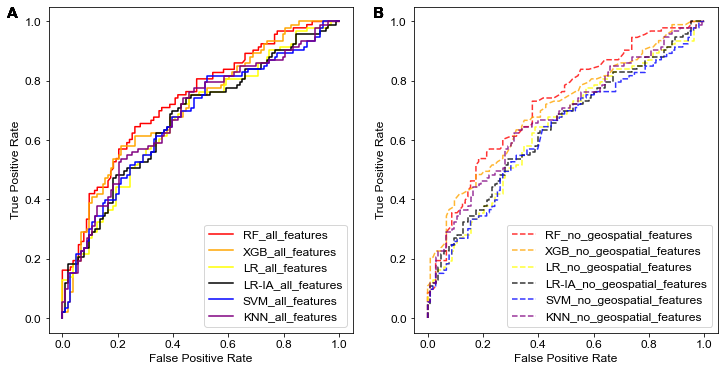

In [68]:
colors = ['red', 'orange', 'yellow', 'black', 'blue', 'purple']

best_models_spatial = [pipeline_rf,pipeline_xgb,pipeline_lg,pipeline_lgp,pipeline_svm,pipeline_knn] # including spatial features
best_models_self = [pipeline_rf_self,pipeline_xgb_self,pipeline_lg_self,pipeline_lgp_self,pipeline_svm_self,pipeline_knn_self] # excluding spatial features

rng = np.random.RandomState(0)
rng_self = np.random.RandomState(0)

X_cv_train_spatial_1 = X_cv_train_spatial_lst[0]
X_cv_val_spatial_1 = X_cv_val_spatial_lst[0]
X_cv_train_self_1 = X_cv_train_self_lst[0]
X_cv_val_self_1 = X_cv_val_self_lst[0]
y_cv_train_1 = y_cv_train_lst[0]
y_cv_val_1 = y_cv_val_lst[0]

fig, axes = plt.subplots(1,2, figsize = (12,6))

fpr_spatial_lst = []
tpr_spatial_lst = []
thresholds_spatial_lst = []
roc_auc_spatial_lst = []

fpr_self_lst = []
tpr_self_lst = []
thresholds_self_lst = []
roc_auc_self_lst = []

for i in np.arange(len(models)):
    model_name = models[i]
    #For including spatial features:
    
    model_spatial = best_models_spatial[i]
    if model_name != 'KNN':
        model_spatial = model_spatial.set_params(**{'est__random_state':rng})
    model_spatial.fit(X_cv_train_spatial_1, y_cv_train_1)
    y_cv_val_1_pred_proba_spatial = model_spatial.predict_proba(X_cv_val_spatial_1)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_cv_val_1, y_cv_val_1_pred_proba_spatial)
    roc_auc_spatial = roc_auc_score(y_cv_val_1, y_cv_val_1_pred_proba_spatial)
    
    fpr_spatial_lst.append(fpr)
    tpr_spatial_lst.append(tpr)
    thresholds_spatial_lst.append(thresholds)
    roc_auc_spatial_lst.append(roc_auc_spatial)
    
    print("ROC AUC of {} using all features including geospatial ones is: {}".format(model_name, roc_auc_spatial))
    axes[0].plot(fpr, tpr, color = colors[i], label = model_name+'_all_features')
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].legend(loc='lower right', fontsize = 12)
    axes[0].text(-0.1, 1, 'A', transform=axes[0].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
    
    # For excluding spatial features:
    model_self = best_models_self[i]
    if model_name != 'KNN':
        model_self = model_self.set_params(**{'est__random_state':rng_self})
    model_self.fit(X_cv_train_self_1, y_cv_train_1)
    y_cv_val_1_pred_proba_self = model_self.predict_proba(X_cv_val_self_1)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_cv_val_1, y_cv_val_1_pred_proba_self)
    roc_auc_self = roc_auc_score(y_cv_val_1, y_cv_val_1_pred_proba_self)
    
    fpr_self_lst.append(fpr)
    tpr_self_lst.append(tpr)
    thresholds_self_lst.append(thresholds)
    roc_auc_self_lst.append(roc_auc_self)
    
    print("ROC AUC of {} excluding geospatial features is: {}".format(model_name, roc_auc_self))
    axes[1].plot(fpr, tpr, '--', color=colors[i],label = model_name + '_no_geospatial_features', alpha = 0.8)
    axes[1].set_xlabel('False Positive Rate', fontsize=12)
    axes[1].set_ylabel('True Positive Rate', fontsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].legend(loc='lower right', fontsize = 12)
    axes[1].text(-0.1, 1, 'B', transform=axes[1].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
    
plt.savefig('./Figures/SI/ROC_curves.png',bbox_inches='tight',dpi=300)

# Select the optimal threshold for the RF model

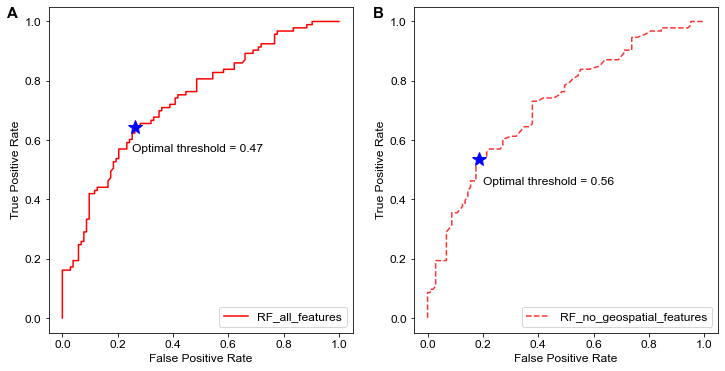

In [69]:
fpr_rf = fpr_spatial_lst[0]
tpr_rf = tpr_spatial_lst[0]
thresholds_rf = thresholds_spatial_lst[0]
opt_idx_rf = np.argmax(tpr_rf - fpr_rf)
thres_opt_rf = thresholds_rf[opt_idx_rf]

fpr_rf_self = fpr_self_lst[0]
tpr_rf_self = tpr_self_lst[0]
thresholds_rf_self = thresholds_self_lst[0]
opt_idx_rf_self = np.argmax(tpr_rf_self - fpr_rf_self)
thres_opt_rf_self = thresholds_rf_self[opt_idx_rf_self]

fig, axes = plt.subplots(1,2, figsize = (12,6))
axes[0].plot(fpr_rf, tpr_rf, color = colors[0], label = models[0]+'_all_features')
axes[0].plot(fpr_rf[opt_idx_rf], tpr_rf[opt_idx_rf], marker = '*', color = 'blue', 
             markersize = 15)# Plot optimal point
axes[0].annotate('Optimal threshold = {:.2f}'.format(thres_opt_rf), (0.25, 0.56),
                ha = 'left', fontsize = 12)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(loc='lower right', fontsize = 12)
axes[0].text(-0.1, 1, 'A', transform=axes[0].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')

axes[1].plot(fpr_rf_self, tpr_rf_self, '--', color=colors[0],label = models[0] + '_no_geospatial_features', alpha = 0.8)
axes[1].plot(fpr_rf_self[opt_idx_rf_self], tpr_rf_self[opt_idx_rf_self], marker = '*', color = 'blue', 
             markersize = 15)# Plot optimal point
axes[1].annotate('Optimal threshold = {:.2f}'.format(thres_opt_rf_self), (0.20, 0.45),
                ha = 'left', fontsize = 12)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(loc='lower right', fontsize = 12)
axes[1].text(-0.1, 1, 'B', transform=axes[1].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')

plt.savefig('./Figures/SI/optimal_threshold.png',bbox_inches='tight',dpi=300)

# Evaluate the RF model on test set using the optimal threshold

In [70]:
# define a function to generate predictions using specified threshold
def predict_using_threshold(y_proba_pred, thres):
    y_pred = (y_proba_pred >= thres).astype('int')
    return y_pred

In [71]:
def test_evaluation(model, threshold, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = predict_using_threshold(y_pred_proba, threshold)
    cm = confusion_matrix(y_test,y_pred, labels=model.classes_)
    roc_auc = roc_auc_score(y_test,y_pred_proba)
    print(cm)
    print(classification_report(y_test,y_pred))
    print('Accuracy: ',accuracy_score(y_test,y_pred))
    print('ROC_AUC: ', roc_auc)

### Using all features

In [72]:
rng = np.random.RandomState(0)
pipeline_rf = pipeline_rf.set_params(**{'est__random_state':rng})
pipeline_rf.fit(X_train_spatial, y_train) # re-fit on the entire training set
test_evaluation(pipeline_rf, thres_opt_rf, X_test_spatial, y_test)

[[95 34]
 [45 71]]
              precision    recall  f1-score   support

       False       0.68      0.74      0.71       129
        True       0.68      0.61      0.64       116

    accuracy                           0.68       245
   macro avg       0.68      0.67      0.67       245
weighted avg       0.68      0.68      0.68       245

Accuracy:  0.6775510204081633
ROC_AUC:  0.7251069232825448


### Excluding geospatial features

In [73]:
rng_self = np.random.RandomState(0)
pipeline_rf_self = pipeline_rf_self.set_params(**{'est__random_state':rng_self})
pipeline_rf_self.fit(X_train_self, y_train) # re-fit on the entire training set
test_evaluation(pipeline_rf_self, thres_opt_rf_self, X_test_self, y_test)

[[101  28]
 [ 56  60]]
              precision    recall  f1-score   support

       False       0.64      0.78      0.71       129
        True       0.68      0.52      0.59       116

    accuracy                           0.66       245
   macro avg       0.66      0.65      0.65       245
weighted avg       0.66      0.66      0.65       245

Accuracy:  0.6571428571428571
ROC_AUC:  0.7038893344025662


# Feature importance of the RF model by SHAP values

### Using all features

In [41]:
rng = np.random.RandomState(0)
pipeline_rf = pipeline_rf.set_params(**{'est__random_state':rng})

# Obtain the final column names:
rf_best_pl = pipeline_rf
rf_cols_0 = rf_best_pl['pre'].feature_names_in_
rf_cols_1 = rf_best_pl['pre'].get_feature_names_out(rf_cols_0)
rf_cols_2 = rf_best_pl['scaler'].get_feature_names_out(rf_cols_1)
rf_cols_3 = rf_best_pl['varFilter'].get_feature_names_out(rf_cols_2)
rf_cols_final = rf_best_pl['UniSlct'].get_feature_names_out(rf_cols_3)
rf_cols_final_clean = [i[1] for i in np.char.split(rf_cols_final.astype(str), sep='__')]
rf_cols_final_clean = np.array([s.replace('_' , ' ') for s in rf_cols_final_clean])

# Transform the X data:
X_pre_rf = rf_best_pl['pre'].transform(X_test_spatial) # use test data for SHAP values
X_scaler_rf = rf_best_pl['scaler'].transform(X_pre_rf)
X_varFilter_rf = rf_best_pl['varFilter'].transform(X_scaler_rf)
X_UniSlct_rf = rf_best_pl['UniSlct'].transform(X_varFilter_rf)
X_processed_rf = pd.DataFrame(X_UniSlct_rf, columns = rf_cols_final_clean)

# Calculate SHAP values:
best_rf_model = rf_best_pl['est']
rf_explainer = shap.TreeExplainer(best_rf_model)
shap_values_rf = rf_explainer(X_processed_rf)

### Excluding geospatial features

In [42]:
rng_self = np.random.RandomState(0)
pipeline_rf_self = pipeline_rf_self.set_params(**{'est__random_state':rng_self})

# Obtain the final column names
rf_self_best_pl = pipeline_rf_self
rf_self_cols_0 = rf_self_best_pl['pre'].feature_names_in_
rf_self_cols_1 = rf_self_best_pl['pre'].get_feature_names_out(rf_self_cols_0)
rf_self_cols_2 = rf_self_best_pl['scaler'].get_feature_names_out(rf_self_cols_1)
rf_self_cols_3 = rf_self_best_pl['varFilter'].get_feature_names_out(rf_self_cols_2)
rf_self_cols_final = rf_self_best_pl['UniSlct'].get_feature_names_out(rf_self_cols_3)
rf_self_cols_final_clean = [i[1] for i in np.char.split(rf_self_cols_final.astype(str), sep='__')]
rf_self_cols_final_clean = np.array([s.replace('_' , ' ') for s in rf_self_cols_final_clean])

# Transform the X data
X_pre_rf_self = rf_self_best_pl['pre'].transform(X_test_spatial) # Use test data for SHAP values
X_scaler_rf_self = rf_self_best_pl['scaler'].transform(X_pre_rf_self)
X_varFilter_rf_self = rf_self_best_pl['varFilter'].transform(X_scaler_rf_self)
X_UniSlct_rf_self = rf_self_best_pl['UniSlct'].transform(X_varFilter_rf_self)
X_processed_rf_self = pd.DataFrame(X_UniSlct_rf_self, columns = rf_self_cols_final_clean)

# Calculate SHAP values:
best_rf_self_model = rf_self_best_pl['est']
rf_self_explainer = shap.TreeExplainer(best_rf_self_model)
shap_values_rf_self = rf_self_explainer(X_processed_rf_self)

### SHAP Beeswarm plot

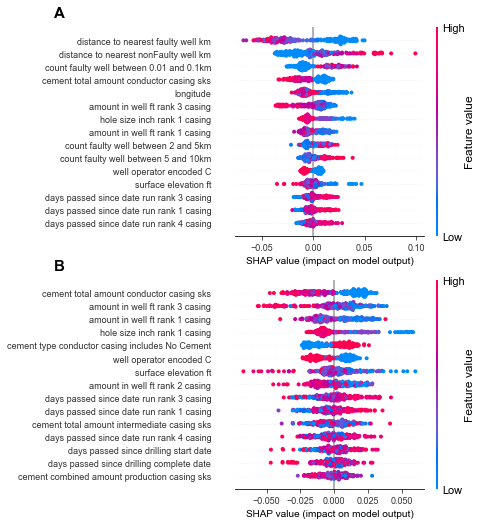

In [43]:
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
shap_sum_plot = shap.summary_plot(shap_values_rf.values[:,:,1], X_processed_rf,max_display=15, show = False)
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.xaxis.label.set_size(10)
ax1.yaxis.label.set_size(10)
ax1.text(-0.9, 1.1, 'A', transform=ax1.transAxes, fontsize=15, fontweight='bold',va='top', ha='right')

ax2 = plt.subplot(2,1,2)
shap_sum_plot_self = shap.summary_plot(shap_values_rf_self.values[:,:,1], X_processed_rf_self,max_display=15, show = False)
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.xaxis.label.set_size(10)
ax2.yaxis.label.set_size(10)
ax2.text(-0.9, 1.1, 'B', transform=ax2.transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
plt.savefig('./Figures/main_text/SHAP_beeswarm.png',bbox_inches='tight',dpi=300)

### SHAP bar plot

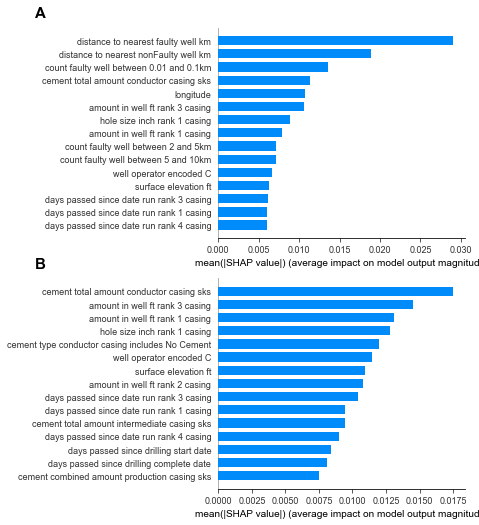

In [44]:
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
shap_sum_plot = shap.summary_plot(shap_values_rf.values[:,:,1], X_processed_rf,max_display=15, show = False,plot_type = 'bar')
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.xaxis.label.set_size(10)
ax1.yaxis.label.set_size(10)
ax1.text(-0.7, 1.1, 'A', transform=ax1.transAxes, fontsize=15, fontweight='bold',va='top', ha='right')

ax2 = plt.subplot(2,1,2)
shap_sum_plot_self = shap.summary_plot(shap_values_rf_self.values[:,:,1], X_processed_rf_self,max_display=15, show = False,plot_type = 'bar')
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.xaxis.label.set_size(10)
ax2.yaxis.label.set_size(10)
ax2.text(-0.7, 1.1, 'B', transform=ax2.transAxes, fontsize=15, fontweight='bold',va='top', ha='right')

plt.savefig('./Figures/SI/SHAP_bar.png',bbox_inches='tight',dpi=300)

# The impacts of tree number and maximum tree depth on the RF model

In [45]:
# This function evaluates the pipeline's performance over different hyper-parameter values

def evaluate_cv_test_on_param(param_name,list_params, pipeline, X_train, y_train, X_test, y_test,X_cv_train_lst, y_cv_train_lst, X_cv_val_lst, y_cv_val_lst):
    list_mean_cv_score = []
    list_std_cv_score = []
    list_test_score = []

    for param in list_params:
        list_cv_score = []
        # set parameters:
        param_cur = {param_name: param}
        pipeline_param = pipeline.set_params(**param_cur)
        # Cross Validation: 
        for i in range(len(X_cv_train_lst)):
            pipeline_param_cv = pipeline_param.fit(X_cv_train_lst[i], y_cv_train_lst[i])   
            y_cv_val_pred_prob = pipeline_param_cv.predict_proba(X_cv_val_lst[i])[:,1]
            score_cur = roc_auc_score(y_cv_val_lst[i],y_cv_val_pred_prob)
            list_cv_score.append(score_cur)
        list_cv_score = np.array(list_cv_score)
        mean_cv_score = np.mean(list_cv_score)
        list_mean_cv_score.append(mean_cv_score)
        std_cv_score = np.std(list_cv_score)
        list_std_cv_score.append(std_cv_score)

        # evaluate on test set
        pipeline_param_test = pipeline_param.fit(X_train, y_train)
        y_test_pred_prob = pipeline_param_test.predict_proba(X_test)[:,1]
        score_test = roc_auc_score(y_test, y_test_pred_prob)
        list_test_score.append(score_test)
        
    return np.array(list_mean_cv_score), np.array(list_std_cv_score), np.array(list_test_score)

## The impact of tree number

In [46]:
list_n_estimators = [10,25, 50, 75, 100, 500, 1000, 1500, 2000, 3000]

### Including all features

In [47]:
rng = np.random.RandomState(0)

rf_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng,n_jobs=-1))
]

rf_pipeline_Nestimator = Pipeline(steps = rf_steps)
rf_params = {'UniSlct__percentile': 100, 'est__max_depth': 200, 'est__max_features': 'log2'}
rf_pipeline_Nestimator = rf_pipeline_Nestimator.set_params(**rf_params)
list_mean_cv_score_rf_Nestimator, list_std_cv_score_rf_Nestimator, list_test_score_rf_Nestimator = evaluate_cv_test_on_param('est__n_estimators',list_n_estimators,rf_pipeline_Nestimator,
                         X_train_spatial, y_train,
                         X_test_spatial, y_test,
                         X_cv_train_spatial_lst, y_cv_train_lst,
                         X_cv_val_spatial_lst,y_cv_val_lst)

### Excluding geospatial features

In [48]:
rng = np.random.RandomState(0)
rf_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng, n_jobs=-1))
]

rf_self_pipeline_Nestimator = Pipeline(steps = rf_steps_self)
rf_self_params = {'UniSlct__percentile': 100, 'est__max_depth': 200, 'est__max_features': 'log2'}
rf_self_pipeline_Nestimator = rf_self_pipeline_Nestimator.set_params(**rf_self_params)
list_mean_cv_score_rf_self_Nestimator, list_std_cv_score_rf_self_Nestimator, list_test_score_rf_self_Nestimator = evaluate_cv_test_on_param('est__n_estimators',list_n_estimators,rf_self_pipeline_Nestimator,
                         X_train_self, y_train,
                         X_test_self, y_test,
                         X_cv_train_self_lst, y_cv_train_lst,
                         X_cv_val_self_lst,y_cv_val_lst)

## The impact of maximum tree depth

In [49]:
list_maxDepth = [1,3,5,10,25, 50, 75, 100,200,500]

### Using all features

In [50]:
rng = np.random.RandomState(0)

rf_steps = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng,n_jobs=-1))
]

rf_pipeline_maxDepth = Pipeline(steps = rf_steps)
rf_params = {'UniSlct__percentile': 100, 'est__n_estimators': 1000,'est__max_features': 'log2'}
rf_pipeline_maxDepth = rf_pipeline_maxDepth.set_params(**rf_params)
list_mean_cv_score_rf_maxDepth, list_std_cv_score_rf_maxDepth, list_test_score_rf_maxDepth = evaluate_cv_test_on_param('est__max_depth',list_maxDepth,rf_pipeline_maxDepth,
                         X_train_spatial, y_train,
                         X_test_spatial, y_test,
                         X_cv_train_spatial_lst, y_cv_train_lst,
                         X_cv_val_spatial_lst,y_cv_val_lst)

### Excluding geospatial features

In [51]:
rng = np.random.RandomState(0)
rf_steps_self = [
     ("pre", create_preprocessor()),
     ("scaler", StandardScaler()),
     ("varFilter", VarianceThreshold(threshold = 0.0)),
     ("UniSlct", SelectPercentile(f_classif)),
     ("est", RandomForestClassifier(random_state=rng, n_jobs=-1))
]

rf_self_pipeline_maxDepth = Pipeline(steps = rf_steps_self)
rf_self_params = {'UniSlct__percentile': 100, 'est__n_estimators': 1000,'est__max_features': 'log2'}
rf_self_pipeline_maxDepth = rf_self_pipeline_maxDepth.set_params(**rf_self_params)
list_mean_cv_score_rf_self_maxDepth, list_std_cv_score_rf_self_maxDepth, list_test_score_rf_self_maxDepth = evaluate_cv_test_on_param('est__max_depth',list_maxDepth,rf_self_pipeline_maxDepth,
                         X_train_self, y_train,
                         X_test_self, y_test,
                         X_cv_train_self_lst, y_cv_train_lst,
                         X_cv_val_self_lst,y_cv_val_lst)

In [52]:
print(list_n_estimators)
print(list_mean_cv_score_rf_Nestimator)

[10, 25, 50, 75, 100, 500, 1000, 1500, 2000, 3000]
[0.72117597 0.74737174 0.74129524 0.74585399 0.74839657 0.75452663
 0.75693856 0.75673714 0.75794471 0.75778686]


In [53]:
print(list_maxDepth)
print(list_mean_cv_score_rf_maxDepth)

[1, 3, 5, 10, 25, 50, 75, 100, 200, 500]
[0.6914315  0.72173979 0.73392976 0.75307207 0.75663586 0.7552198
 0.75722505 0.7584214  0.75696036 0.75644888]


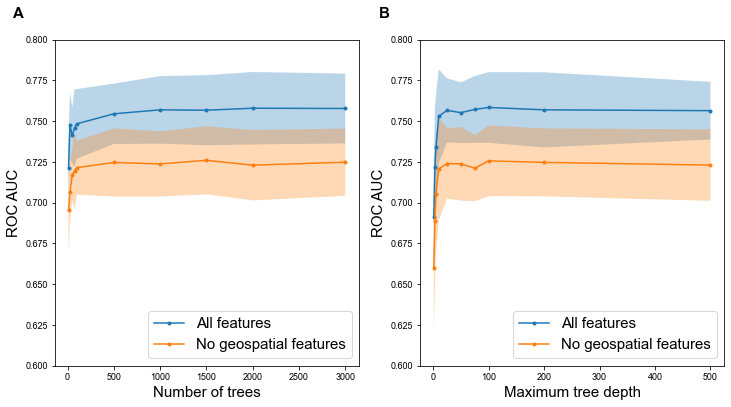

In [54]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(list_n_estimators, list_mean_cv_score_rf_Nestimator,'.-',label = 'All features')
axes[0].fill_between(list_n_estimators, list_mean_cv_score_rf_Nestimator- list_std_cv_score_rf_Nestimator, 
                    list_mean_cv_score_rf_Nestimator + list_std_cv_score_rf_Nestimator, alpha=0.3)

axes[0].plot(list_n_estimators, list_mean_cv_score_rf_self_Nestimator, '.-',label = 'No geospatial features')
axes[0].fill_between(list_n_estimators, list_mean_cv_score_rf_self_Nestimator - list_std_cv_score_rf_self_Nestimator,
                    list_mean_cv_score_rf_self_Nestimator + list_std_cv_score_rf_self_Nestimator, alpha=0.3)
axes[0].set_ylim(0.6,0.8)
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[0].xaxis.label.set_size(10)
axes[0].yaxis.label.set_size(10)
axes[0].text(-0.1, 1.1, 'A', transform=axes[0].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
axes[0].set_xlabel('Number of trees', fontsize = 15)
axes[0].set_ylabel('ROC AUC', fontsize = 15)
axes[0].legend(loc = 'lower right',fontsize = 15)

axes[1].plot(list_maxDepth, list_mean_cv_score_rf_maxDepth,'.-',label = 'All features')
axes[1].fill_between(list_maxDepth,list_mean_cv_score_rf_maxDepth - list_std_cv_score_rf_maxDepth,
            list_mean_cv_score_rf_maxDepth + list_std_cv_score_rf_maxDepth,alpha=0.3)

axes[1].plot(list_maxDepth, list_mean_cv_score_rf_self_maxDepth, '.-',label = 'No geospatial features')
axes[1].fill_between(list_maxDepth, list_mean_cv_score_rf_self_maxDepth - list_std_cv_score_rf_self_maxDepth,
                    list_mean_cv_score_rf_self_maxDepth + list_std_cv_score_rf_self_maxDepth,alpha=0.3)

axes[1].set_ylim(0.6,0.8)
axes[1].tick_params(axis='both', which='major', labelsize=9)
axes[1].xaxis.label.set_size(10)
axes[1].yaxis.label.set_size(10)
axes[1].text(-0.1, 1.1, 'B', transform=axes[1].transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
axes[1].set_xlabel('Maximum tree depth', fontsize = 15)
axes[1].set_ylabel('ROC AUC', fontsize = 15)
axes[1].legend(loc = 'lower right',fontsize = 15)

plt.savefig('./Figures/SI/tree_number_depth.png',bbox_inches='tight',dpi=300)